# PHATE Regularized Autoencoder

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import phate
import scipy
import scanpy as sc
from typing import List, Union, Optional, Tuple

In [31]:
class Autoencoder(nn.Module):
    """
    Simple autoencoder for dimensionality reduction with distance preservation.
    """
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_dims: List[int] = [128, 64]
    ):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Build encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Build decoder
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode input to latent space"""
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode from latent space to input space"""
        return self.decoder(z)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Full forward pass"""
        z = self.encode(x)
        return self.decode(z)

In [32]:
adata = sc.read_h5ad('adata_time.h5ad')

In [33]:
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'pseudotime'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

In [34]:
# Check the shapes of our data
print(f"Raw data shape: {adata.X.shape}")
print(f"PHATE embedding shape: {adata.obsm['X_phate'].shape}")
print(f"Data type: {type(adata.X)}")
print(f"PHATE data type: {type(adata.obsm['X_phate'])}")

# Check for any missing values
import numpy as np
# Convert sparse matrix to dense for NaN check
if scipy.sparse.issparse(adata.X):
    print(f"Raw data has NaN values: {np.isnan(adata.X.toarray()).any()}")
else:
    print(f"Raw data has NaN values: {np.isnan(adata.X).any()}")
print(f"PHATE has NaN values: {np.isnan(adata.obsm['X_phate']).any()}")

Raw data shape: (17944, 18019)
PHATE embedding shape: (17944, 2)
Data type: <class 'scipy.sparse._csr.csr_matrix'>
PHATE data type: <class 'numpy.ndarray'>
Raw data has NaN values: False
PHATE has NaN values: False


In [35]:
# Check PCA dimensions
print(f"PCA shape: {adata.obsm['X_pca'].shape}")
print(f"Available obsm keys: {list(adata.obsm.keys())}")
print(f"PCA data type: {type(adata.obsm['X_pca'])}")
print(f"PCA has NaN values: {np.isnan(adata.obsm['X_pca']).any()}")

PCA shape: (17944, 50)
Available obsm keys: ['X_pca', 'X_phate']
PCA data type: <class 'numpy.ndarray'>
PCA has NaN values: False


In [36]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

class PhateDataset(Dataset):
    """
    Dataset class for PHATE regularized autoencoder training.
    Includes PCA data and precomputed PHATE distances.
    """
    def __init__(self, adata, batch_size=256, normalize=True):
        """
        Args:
            adata: AnnData object with obsm['X_pca'] (PCA data) and obsm['X_phate'] (PHATE embedding)
            batch_size: Size of batches for pairwise distance computation
            normalize: Whether to normalize the PCA data
        """
        # Extract PCA data instead of raw gene expression
        self.X = adata.obsm['X_pca'].astype(np.float32)
        
        # Normalize if requested
        if normalize:
            scaler = StandardScaler()
            self.X = scaler.fit_transform(self.X).astype(np.float32)
        
        # Extract PHATE embedding
        self.X_phate = adata.obsm['X_phate'].astype(np.float32)
        
        # Normalize PHATE embedding if requested
        if normalize:
            scaler_phate = StandardScaler()
            self.X_phate = scaler_phate.fit_transform(self.X_phate).astype(np.float32)
        
        # Precompute pairwise distances in PHATE space
        print("Computing pairwise PHATE distances...")
        self.phate_distances = pairwise_distances(self.X_phate, metric='euclidean').astype(np.float32)
        
        self.n_samples = self.X.shape[0]
        self.batch_size = batch_size
        
        print(f"Dataset initialized with {self.n_samples} samples")
        print(f"PCA data shape: {self.X.shape}")
        print(f"PHATE embedding shape: {self.X_phate.shape}")
        print(f"PHATE distance matrix shape: {self.phate_distances.shape}")
    
    def __len__(self):
        # Number of batches we can create
        return (self.n_samples + self.batch_size - 1) // self.batch_size
    
    def __getitem__(self, idx):
        """
        Get a batch of data with corresponding PHATE distances
        """
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.n_samples)
        
        # Get batch indices
        batch_indices = np.arange(start_idx, end_idx)
        
        # Get batch data
        batch_x = torch.from_numpy(self.X[batch_indices])
        
        # Get pairwise distances for this batch
        batch_distances = self.phate_distances[np.ix_(batch_indices, batch_indices)]
        # Convert distance matrix to vector format (upper triangular)
        batch_distances_vec = torch.from_numpy(batch_distances[np.triu_indices(len(batch_indices), k=1)])
        
        return {
            'x': batch_x,
            'd': batch_distances_vec,
            'indices': torch.from_numpy(batch_indices.astype(np.int64))
        }

In [37]:
def train_phate_autoencoder(
    model: Autoencoder,
    dataset: PhateDataset,
    num_epochs: int,
    learning_rate: float = 1e-3,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    recon_weight: float = 1.0,
    phate_weight: float = 1.0,
    validation_split: float = 0.2
) -> dict:
    """
    Train autoencoder with PHATE distance regularization.
    
    Args:
        model: The autoencoder model
        dataset: PhateDataset containing gene expression and PHATE distances
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        device: Device to train on
        recon_weight: Weight for reconstruction loss
        phate_weight: Weight for PHATE distance preservation loss
        validation_split: Fraction of data to use for validation
        
    Returns:
        Training history dictionary
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Create train/validation split
    total_batches = len(dataset)
    val_batches = int(total_batches * validation_split)
    train_batches = total_batches - val_batches
    
    # Create data loaders
    train_loader = DataLoader(
        torch.utils.data.Subset(dataset, range(train_batches)), 
        batch_size=1, 
        shuffle=True
    )
    val_loader = DataLoader(
        torch.utils.data.Subset(dataset, range(train_batches, total_batches)), 
        batch_size=1, 
        shuffle=False
    ) if val_batches > 0 else None
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'recon_loss': [],
        'phate_loss': []
    }
    
    print(f'Training PHATE Autoencoder on device: {device}')
    print(f'Reconstruction weight: {recon_weight}, PHATE weight: {phate_weight}')
    print(f'Train batches: {train_batches}, Validation batches: {val_batches}')
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        # Training phase
        model.train()
        train_loss = 0.0
        recon_loss_sum = 0.0
        phate_loss_sum = 0.0
        
        for batch in train_loader:
            data = batch['x'].squeeze(0).to(device)  # Remove batch dimension added by DataLoader
            phate_distances = batch['d'].squeeze(0).to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            embedding = model.encode(data)
            reconstructed = model.decode(embedding)
            
            # Reconstruction loss
            recon_loss = criterion(reconstructed, data)
            
            # PHATE distance preservation loss
            # Compute pairwise distances in latent space
            if embedding.shape[0] > 1:  # Only compute if we have more than 1 sample
                latent_distances = torch.pdist(embedding)
                phate_loss = criterion(latent_distances, phate_distances)
            else:
                phate_loss = torch.tensor(0.0, device=device)
            
            # Combined loss
            loss = recon_weight * recon_loss + phate_weight * phate_loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            recon_loss_sum += recon_loss.item()
            phate_loss_sum += phate_loss.item()
        
        # Average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_recon_loss = recon_loss_sum / len(train_loader)
        avg_phate_loss = phate_loss_sum / len(train_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['phate_loss'].append(avg_phate_loss)
        
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_recon_loss_sum = 0.0
            val_phate_loss_sum = 0.0
            
            with torch.no_grad():
                for batch in val_loader:
                    data = batch['x'].squeeze(0).to(device)
                    phate_distances = batch['d'].squeeze(0).to(device)
                    
                    embedding = model.encode(data)
                    reconstructed = model.decode(embedding)
                    
                    recon_loss = criterion(reconstructed, data)
                    if embedding.shape[0] > 1:
                        latent_distances = torch.pdist(embedding)
                        phate_loss = criterion(latent_distances, phate_distances)
                    else:
                        phate_loss = torch.tensor(0.0, device=device)
                        
                    loss = recon_weight * recon_loss + phate_weight * phate_loss
                    
                    val_loss += loss.item()
                    val_recon_loss_sum += recon_loss.item()
                    val_phate_loss_sum += phate_loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)
            
            if epoch % 10 == 0:  # Print every 10 epochs
                tqdm.write(f'Epoch {epoch+1:3d}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
                          f'Recon: {avg_recon_loss:.4f}, PHATE: {avg_phate_loss:.4f}')
        else:
            if epoch % 10 == 0:
                tqdm.write(f'Epoch {epoch+1:3d}: Train Loss: {avg_train_loss:.4f}, '
                          f'Recon: {avg_recon_loss:.4f}, PHATE: {avg_phate_loss:.4f}')
    
    return history

In [ ]:
# Create new dataset with PCA data
print("Creating PHATE dataset with PCA input...")
phate_dataset_pca = PhateDataset(adata, batch_size=1024, normalize=True)

Creating PHATE dataset with PCA input...
Computing pairwise PHATE distances...
Dataset initialized with 17944 samples
PCA data shape: (17944, 50)
PHATE embedding shape: (17944, 2)
PHATE distance matrix shape: (17944, 17944)
Creating autoencoder with input_dim=50, latent_dim=2
Total parameters: 7,668
Model architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)


In [ ]:
phate_dataset_pca2 = PointCloudDataset(
    

In [60]:

# Create new autoencoder model for PCA input
input_dim = adata.obsm['X_pca'].shape[1]  # Number of PCA components
latent_dim = 2  # Smaller latent dimension since input is already reduced
hidden_dims = [32, 32, 32]  # Smaller hidden layers for PCA input

print(f"Creating autoencoder with input_dim={input_dim}, latent_dim={latent_dim}")
model_pca = Autoencoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims)

# Print model summary
total_params = sum(p.numel() for p in model_pca.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Model architecture:")
print(model_pca)

Creating autoencoder with input_dim=50, latent_dim=2
Total parameters: 7,668
Model architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)


In [ ]:
# Train the PHATE regularized autoencoder with PCA input
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 500
learning_rate = 1e-2
recon_weight = 0.01
phate_weight = 1.0  # Higher weight since we have fewer parameters

print("Starting training with PCA input...")
history_pca = train_phate_autoencoder(
    model=model_pca,
    dataset=phate_dataset_pca,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    recon_weight=recon_weight,
    phate_weight=phate_weight,
    validation_split=0.2
)

Using device: cpu
Starting training with PCA input...
Training PHATE Autoencoder on device: cpu
Reconstruction weight: 0.01, PHATE weight: 1.0
Train batches: 15, Validation batches: 3


Epochs:   0%|          | 1/500 [00:00<03:45,  2.21it/s]

Epoch   1: Train Loss: 0.7384, Val Loss: 0.6977, Recon: 0.9438, PHATE: 0.7289


Epochs:   2%|▏         | 11/500 [00:04<03:22,  2.41it/s]

Epoch  11: Train Loss: 0.1890, Val Loss: 0.1030, Recon: 0.8830, PHATE: 0.1802


Epochs:   4%|▍         | 21/500 [00:08<03:29,  2.29it/s]

Epoch  21: Train Loss: 0.0689, Val Loss: 0.0853, Recon: 0.8694, PHATE: 0.0603


Epochs:   6%|▌         | 31/500 [00:13<03:18,  2.36it/s]

Epoch  31: Train Loss: 0.0607, Val Loss: 0.0695, Recon: 0.8401, PHATE: 0.0523


Epochs:   8%|▊         | 41/500 [00:17<03:09,  2.43it/s]

Epoch  41: Train Loss: 0.0447, Val Loss: 0.0665, Recon: 0.8138, PHATE: 0.0366


Epochs:  10%|█         | 51/500 [00:21<03:04,  2.43it/s]

Epoch  51: Train Loss: 0.0630, Val Loss: 0.0719, Recon: 0.8422, PHATE: 0.0546


Epochs:  12%|█▏        | 61/500 [00:25<03:00,  2.43it/s]

Epoch  61: Train Loss: 0.0358, Val Loss: 0.0593, Recon: 0.7900, PHATE: 0.0279


Epochs:  14%|█▍        | 71/500 [00:29<02:58,  2.40it/s]

Epoch  71: Train Loss: 0.0480, Val Loss: 0.0631, Recon: 0.7891, PHATE: 0.0401


Epochs:  16%|█▌        | 81/500 [00:33<02:57,  2.36it/s]

Epoch  81: Train Loss: 0.0625, Val Loss: 0.0620, Recon: 0.7887, PHATE: 0.0546


Epochs:  18%|█▊        | 91/500 [00:38<02:49,  2.42it/s]

Epoch  91: Train Loss: 0.0330, Val Loss: 0.0555, Recon: 0.7648, PHATE: 0.0254


Epochs:  20%|██        | 101/500 [00:42<02:45,  2.41it/s]

Epoch 101: Train Loss: 0.0520, Val Loss: 0.0603, Recon: 0.7732, PHATE: 0.0443


Epochs:  22%|██▏       | 111/500 [00:46<02:40,  2.42it/s]

Epoch 111: Train Loss: 0.0295, Val Loss: 0.0551, Recon: 0.7677, PHATE: 0.0218


Epochs:  24%|██▍       | 121/500 [00:50<02:39,  2.38it/s]

Epoch 121: Train Loss: 0.0264, Val Loss: 0.0553, Recon: 0.7529, PHATE: 0.0189


Epochs:  26%|██▌       | 131/500 [00:55<02:32,  2.42it/s]

Epoch 131: Train Loss: 0.0289, Val Loss: 0.0548, Recon: 0.7626, PHATE: 0.0212


Epochs:  28%|██▊       | 141/500 [00:59<02:36,  2.29it/s]

Epoch 141: Train Loss: 0.0249, Val Loss: 0.0528, Recon: 0.7506, PHATE: 0.0174


Epochs:  30%|███       | 151/500 [01:03<02:23,  2.42it/s]

Epoch 151: Train Loss: 0.0246, Val Loss: 0.0530, Recon: 0.7493, PHATE: 0.0171


Epochs:  32%|███▏      | 161/500 [01:07<02:21,  2.39it/s]

Epoch 161: Train Loss: 0.0561, Val Loss: 0.0862, Recon: 0.8900, PHATE: 0.0472


Epochs:  34%|███▍      | 171/500 [01:11<02:15,  2.42it/s]

Epoch 171: Train Loss: 0.0336, Val Loss: 0.0615, Recon: 0.8419, PHATE: 0.0252


Epochs:  36%|███▌      | 181/500 [01:15<02:11,  2.43it/s]

Epoch 181: Train Loss: 0.0316, Val Loss: 0.0585, Recon: 0.8297, PHATE: 0.0233


Epochs:  38%|███▊      | 191/500 [01:20<02:08,  2.41it/s]

Epoch 191: Train Loss: 0.0358, Val Loss: 0.0580, Recon: 0.8038, PHATE: 0.0277


Epochs:  40%|████      | 201/500 [01:24<02:04,  2.41it/s]

Epoch 201: Train Loss: 0.0356, Val Loss: 0.0604, Recon: 0.8123, PHATE: 0.0275


Epochs:  42%|████▏     | 211/500 [01:28<02:00,  2.40it/s]

Epoch 211: Train Loss: 0.0253, Val Loss: 0.0625, Recon: 0.7828, PHATE: 0.0175


Epochs:  44%|████▍     | 221/500 [01:32<01:55,  2.42it/s]

Epoch 221: Train Loss: 0.0271, Val Loss: 0.0583, Recon: 0.7792, PHATE: 0.0193


Epochs:  46%|████▌     | 231/500 [01:36<01:52,  2.40it/s]

Epoch 231: Train Loss: 0.0288, Val Loss: 0.0670, Recon: 0.7764, PHATE: 0.0210


Epochs:  48%|████▊     | 241/500 [01:40<01:47,  2.41it/s]

Epoch 241: Train Loss: 0.0287, Val Loss: 0.0577, Recon: 0.7839, PHATE: 0.0209


Epochs:  50%|█████     | 251/500 [01:44<01:43,  2.41it/s]

Epoch 251: Train Loss: 0.0299, Val Loss: 0.0560, Recon: 0.7939, PHATE: 0.0220


Epochs:  52%|█████▏    | 261/500 [01:49<01:43,  2.30it/s]

Epoch 261: Train Loss: 0.0289, Val Loss: 0.0565, Recon: 0.7771, PHATE: 0.0211


Epochs:  54%|█████▍    | 271/500 [01:53<01:36,  2.38it/s]

Epoch 271: Train Loss: 0.0250, Val Loss: 0.0550, Recon: 0.7709, PHATE: 0.0173


Epochs:  56%|█████▌    | 281/500 [01:57<01:30,  2.42it/s]

Epoch 281: Train Loss: 0.0243, Val Loss: 0.0539, Recon: 0.7692, PHATE: 0.0166


Epochs:  58%|█████▊    | 291/500 [02:01<01:26,  2.41it/s]

Epoch 291: Train Loss: 0.0417, Val Loss: 0.0601, Recon: 0.7884, PHATE: 0.0338


Epochs:  60%|██████    | 301/500 [02:06<01:22,  2.42it/s]

Epoch 301: Train Loss: 0.0258, Val Loss: 0.0560, Recon: 0.7651, PHATE: 0.0181


Epochs:  62%|██████▏   | 311/500 [02:10<01:19,  2.37it/s]

Epoch 311: Train Loss: 0.0385, Val Loss: 0.0642, Recon: 0.7928, PHATE: 0.0305


Epochs:  64%|██████▍   | 321/500 [02:14<01:17,  2.31it/s]

Epoch 321: Train Loss: 0.0237, Val Loss: 0.0562, Recon: 0.7721, PHATE: 0.0160


Epochs:  66%|██████▌   | 331/500 [02:18<01:10,  2.38it/s]

Epoch 331: Train Loss: 0.0445, Val Loss: 0.0560, Recon: 0.8301, PHATE: 0.0362


Epochs:  68%|██████▊   | 341/500 [02:23<01:05,  2.42it/s]

Epoch 341: Train Loss: 0.0258, Val Loss: 0.0574, Recon: 0.7742, PHATE: 0.0181


Epochs:  70%|███████   | 351/500 [02:27<01:02,  2.40it/s]

Epoch 351: Train Loss: 0.0225, Val Loss: 0.0532, Recon: 0.7677, PHATE: 0.0148


Epochs:  72%|███████▏  | 361/500 [02:31<00:57,  2.43it/s]

Epoch 361: Train Loss: 0.0274, Val Loss: 0.0561, Recon: 0.7684, PHATE: 0.0197


Epochs:  74%|███████▍  | 371/500 [02:35<00:54,  2.35it/s]

Epoch 371: Train Loss: 0.0584, Val Loss: 0.0654, Recon: 0.8241, PHATE: 0.0502


Epochs:  76%|███████▌  | 381/500 [02:39<00:50,  2.38it/s]

Epoch 381: Train Loss: 0.0319, Val Loss: 0.0590, Recon: 0.8011, PHATE: 0.0239


Epochs:  78%|███████▊  | 391/500 [02:44<00:45,  2.40it/s]

Epoch 391: Train Loss: 0.0228, Val Loss: 0.0631, Recon: 0.7602, PHATE: 0.0152


Epochs:  80%|████████  | 401/500 [02:48<00:47,  2.06it/s]

Epoch 401: Train Loss: 0.0218, Val Loss: 0.0593, Recon: 0.7597, PHATE: 0.0142


Epochs:  82%|████████▏ | 411/500 [02:52<00:37,  2.38it/s]

Epoch 411: Train Loss: 0.0219, Val Loss: 0.0573, Recon: 0.7577, PHATE: 0.0144


Epochs:  84%|████████▍ | 421/500 [02:57<00:33,  2.38it/s]

Epoch 421: Train Loss: 0.0220, Val Loss: 0.0549, Recon: 0.7593, PHATE: 0.0144


Epochs:  86%|████████▌ | 431/500 [03:01<00:28,  2.41it/s]

Epoch 431: Train Loss: 0.0298, Val Loss: 0.0622, Recon: 0.7781, PHATE: 0.0221


Epochs:  88%|████████▊ | 441/500 [03:05<00:24,  2.41it/s]

Epoch 441: Train Loss: 0.0256, Val Loss: 0.0545, Recon: 0.7644, PHATE: 0.0180


Epochs:  90%|█████████ | 451/500 [03:09<00:20,  2.40it/s]

Epoch 451: Train Loss: 0.1259, Val Loss: 0.1603, Recon: 0.9115, PHATE: 0.1168


Epochs:  92%|█████████▏| 461/500 [03:13<00:16,  2.31it/s]

Epoch 461: Train Loss: 0.0542, Val Loss: 0.0632, Recon: 0.8343, PHATE: 0.0458


Epochs:  94%|█████████▍| 471/500 [03:18<00:11,  2.42it/s]

Epoch 471: Train Loss: 0.0885, Val Loss: 0.1260, Recon: 0.8265, PHATE: 0.0803


Epochs:  96%|█████████▌| 481/500 [03:22<00:07,  2.42it/s]

Epoch 481: Train Loss: 0.0283, Val Loss: 0.0565, Recon: 0.7709, PHATE: 0.0205


Epochs:  98%|█████████▊| 491/500 [03:26<00:03,  2.41it/s]

Epoch 491: Train Loss: 0.0269, Val Loss: 0.0585, Recon: 0.7722, PHATE: 0.0191


Epochs: 100%|██████████| 500/500 [03:30<00:00,  2.38it/s]


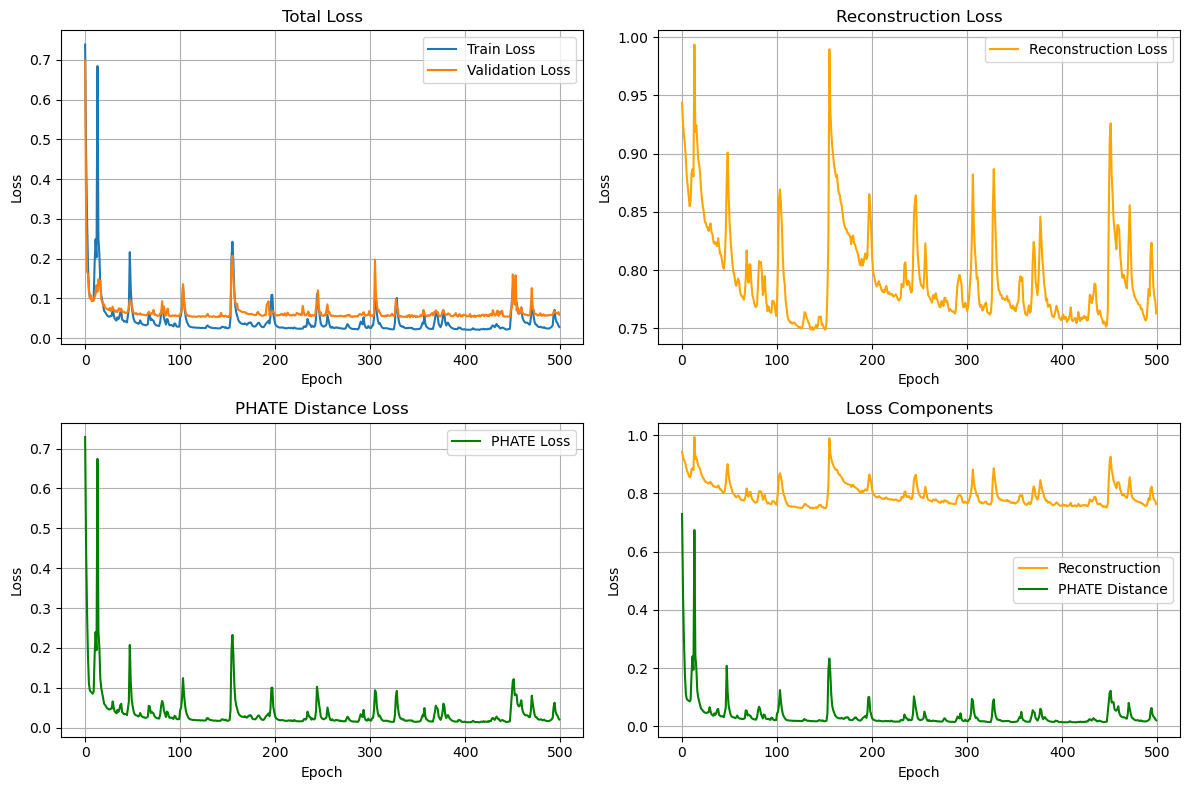

Final training loss: 0.0281
Final reconstruction loss: 0.7628
Final PHATE loss: 0.0205
Final validation loss: 0.0587


In [63]:
# Visualize training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot training and validation loss
axes[0, 0].plot(history_pca['train_loss'], label='Train Loss')
if history_pca['val_loss']:
    axes[0, 0].plot(history_pca['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot reconstruction loss
axes[0, 1].plot(history_pca['recon_loss'], label='Reconstruction Loss', color='orange')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot PHATE loss
axes[1, 0].plot(history_pca['phate_loss'], label='PHATE Loss', color='green')
axes[1, 0].set_title('PHATE Distance Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot loss components
axes[1, 1].plot(history_pca['recon_loss'], label='Reconstruction', color='orange')
axes[1, 1].plot(history_pca['phate_loss'], label='PHATE Distance', color='green')
axes[1, 1].set_title('Loss Components')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final training loss: {history_pca['train_loss'][-1]:.4f}")
print(f"Final reconstruction loss: {history_pca['recon_loss'][-1]:.4f}")
print(f"Final PHATE loss: {history_pca['phate_loss'][-1]:.4f}")
if history_pca['val_loss']:
    print(f"Final validation loss: {history_pca['val_loss'][-1]:.4f}")

In [64]:
# Generate latent embeddings using the trained autoencoder
model_pca.eval()
device = next(model_pca.parameters()).device

# Get PCA data
pca_data = torch.from_numpy(phate_dataset_pca.X).to(device)

# Generate latent embeddings
with torch.no_grad():
    latent_embeddings = model_pca.encode(pca_data).cpu().numpy()
    reconstructed_pca = model_pca.decode(model_pca.encode(pca_data)).cpu().numpy()

print(f"Latent embeddings shape: {latent_embeddings.shape}")
print(f"Original PCA shape: {phate_dataset_pca.X.shape}")
print(f"Reconstructed PCA shape: {reconstructed_pca.shape}")

# Store embeddings in adata for comparison
adata.obsm['X_phate_ae'] = latent_embeddings

Latent embeddings shape: (17944, 2)
Original PCA shape: (17944, 50)
Reconstructed PCA shape: (17944, 50)


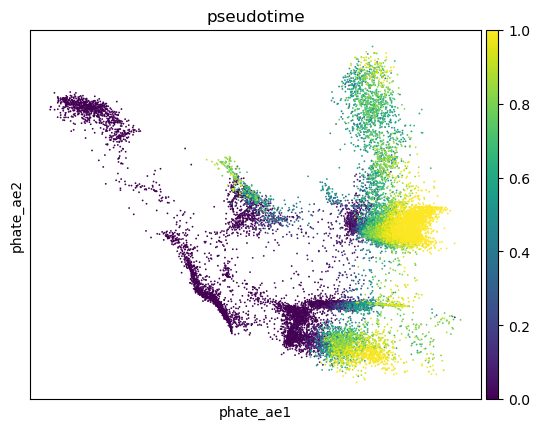

In [65]:
sc.pl.embedding(adata, basis='phate_ae', color=['pseudotime'])

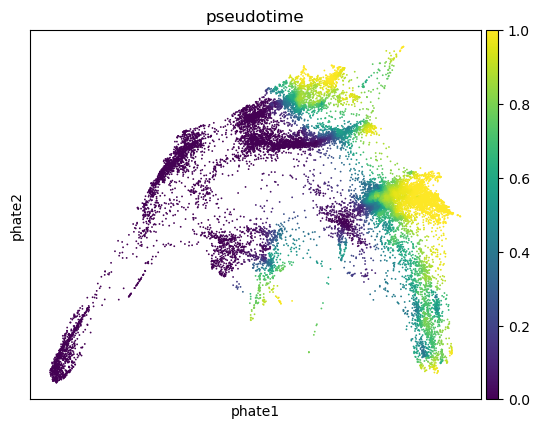

In [66]:
sc.pl.embedding(adata, basis='phate', color=['pseudotime'])

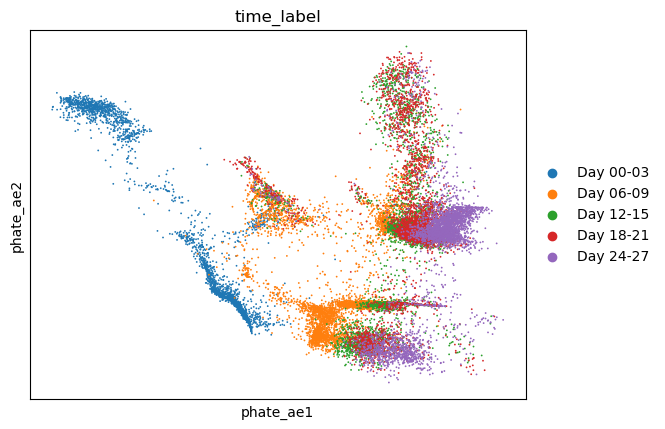

In [73]:
sc.pl.embedding(adata, basis='phate_ae', color=['time_label'])

In [74]:
adata.obs['time_label'].value_counts()

time_label
Day 06-09    4443
Day 18-21    3910
Day 24-27    3563
Day 12-15    3494
Day 00-03    2534
Name: count, dtype: int64

In [75]:
adata.obs['time_bin'] = adata.obs['time_label'].map({
    'Day 00-03': 0.,
    'Day 06-09': 1.,
    'Day 12-15': 2.,
    'Day 18-21': 3.,
    'Day 24-27': 4.,
})

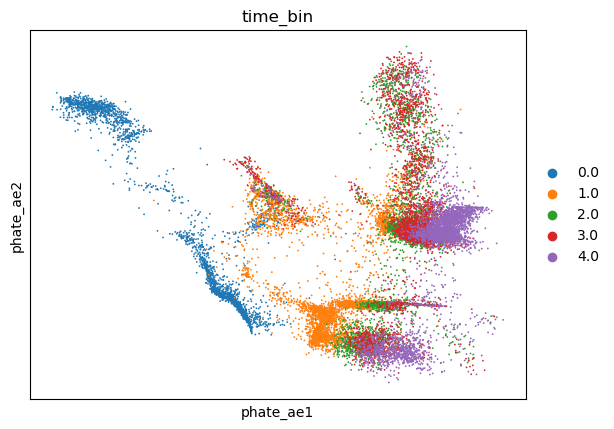

In [76]:
sc.pl.embedding(adata, basis='phate_ae', color=['time_bin'])

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import ot
from torchdiffeq import odeint
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Tuple

class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim), # additional dim for time t.
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, t, x):
        # t is scalar, x is [batch_size, input_dim]
        # Expand t to [batch_size, 1] to match x's batch dimension
        t_expanded = t.expand(x.size(0), 1)
        input = torch.cat([t_expanded, x], dim=-1)
        return self.model(input)

def ot_loss(source, target):
    mu = torch.tensor(ot.unif(source.size()[0]), dtype=source.dtype, device=source.device)
    nu = torch.tensor(ot.unif(target.size()[0]), dtype=target.dtype, device=target.device)
    M = torch.cdist(source, target)**2
    return ot.emd2(mu, nu, M)

def energy_loss(model, x0, t_seq):
    """
    Compute energy loss by evaluating vector field magnitude along the ODE trajectory.
    This penalizes large vector field values to encourage smoother flows.

    Args:
        model: ODEFunc model
        x0: Initial points [batch_size, input_dim]
        t_seq: Time sequence [num_times]

    Returns:
        Energy loss (mean squared magnitude of vector field along trajectory)
    """
    # Compute the full trajectory
    trajectory = odeint(model, x0, t_seq)  # [time_steps, batch_size, input_dim]

    total_energy = 0.0
    num_evaluations = 0

    # Evaluate vector field at each point along the trajectory
    for i, t_val in enumerate(t_seq):
        # Current points at time t_val: trajectory[i]
        x_t = trajectory[i]  # [batch_size, input_dim]

        # Create time tensor for all batch points
        t_tensor = torch.full((x_t.size(0), 1), t_val, device=x_t.device, dtype=x_t.dtype)

        # Get vector field (dx/dt) at current trajectory points
        dx_dt = model(t_tensor, x_t)

        # Add squared magnitude (L2 norm squared for each point)
        total_energy += torch.sum(dx_dt ** 2)
        num_evaluations += x_t.size(0)

    # Return average energy across all trajectory evaluations
    return total_energy / num_evaluations

def density_loss(source, target, top_k=5, hinge_value=0.01):
    """
    Density loss that encourages points to be close to target distribution.
    Uses hinge loss on k-nearest neighbor distances.
    """
    c_dist = torch.cdist(source, target)
    values, _ = torch.topk(c_dist, top_k, dim=1, largest=False, sorted=False)
    values = torch.clamp(values - hinge_value, min=0.0)
    return torch.mean(values)


def infer(x0, model, t_seq):
    return odeint(model, x0, t_seq)


class TimeSeriesDataset(Dataset):
    """
    Dataset for time series data with variable number of points per time step.
    Data format: list of (X_t, t) tuples, where X_t has shape [n_points, dim]
    """
    def __init__(self, time_series_data: List[Tuple[np.ndarray, float]]):
        """
        Args:
            time_series_data: List of (X_t, t) tuples, where X_t is [n_points, dim] array
        """
        self.time_series_data = time_series_data
        self.times = [t for _, t in time_series_data]

    def __len__(self):
        return len(self.time_series_data) - 1  # Number of intervals

    def __getitem__(self, idx):
        """
        Returns data for training interval idx -> idx+1
        """
        X_t, t_start = self.time_series_data[idx]
        X_t1, t_end = self.time_series_data[idx + 1]

        return {
            'X_start': torch.tensor(X_t, dtype=torch.float32),
            'X_end': torch.tensor(X_t1, dtype=torch.float32),
            't_start': t_start,
            't_end': t_end,
            'interval_idx': idx
        }

    def get_time_sequence(self, start_idx=0, end_idx=None):
        """Get time sequence from start_idx to end_idx"""
        if end_idx is None:
            end_idx = len(self.times)
        return torch.tensor(self.times[start_idx:end_idx], dtype=torch.float32)

    def get_initial_condition(self, start_idx=0):
        """Get initial condition X_0"""
        X_0, _ = self.time_series_data[start_idx]
        return torch.tensor(X_0, dtype=torch.float32)


def train_mioflow(
    model: ODEFunc,
    dataset: TimeSeriesDataset,
    num_epochs: int,
    mode: str = 'local',  # 'local' or 'global'
    batch_size: int = None,  # For local mode, how many points to sample per time step
    learning_rate: float = 1e-3,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    lambda_ot: float = 1.0,
    lambda_density: float = 0.1,
    lambda_energy: float = 0.01,
    energy_time_steps: int = 10
) -> Dict:
    """
    Train MioFlow model.

    Args:
        model: ODEFunc model
        dataset: TimeSeriesDataset
        num_epochs: Number of training epochs
        mode: 'local' (train each interval) or 'global' (train full trajectory)
        batch_size: For local mode, number of points to sample per time step (None = use all)
        learning_rate: Learning rate
        device: Device to train on
        lambda_ot: Weight for OT loss
        lambda_density: Weight for density loss
        lambda_energy: Weight for energy regularization
        energy_time_steps: Number of time steps for energy evaluation

    Returns:
        Training history
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'epoch': [],
        'total_loss': [],
        'ot_loss': [],
        'density_loss': [],
        'energy_loss': []
    }

    epoch_pbar = tqdm(range(num_epochs), desc='Epochs')
    for epoch in epoch_pbar:
        epoch_losses = {'total': 0.0, 'ot': 0.0, 'density': 0.0, 'energy': 0.0}
        num_batches = 0

        if mode == 'local':
            # Local mode: train each time interval separately
            for interval_idx in range(len(dataset)):
                batch = dataset[interval_idx]

                X_start = batch['X_start'].to(device)
                X_end = batch['X_end'].to(device)
                t_start = batch['t_start']
                t_end = batch['t_end']

                # Sample points if batch_size specified
                if batch_size is not None:
                    min_size = min(X_start.size(0), X_end.size(0))
                    effective_batch_size = min(batch_size, min_size)
                    indices = torch.randperm(min_size)[:effective_batch_size]
                    X_start = X_start[indices]
                    X_end = X_end[indices]

                # Integrate from X_start to predict X_end
                t_interval = torch.tensor([t_start, t_end], device=device, dtype=torch.float32)
                X_pred = odeint(model, X_start, t_interval)[1]  # Get final time point

                # Compute losses
                ot_loss_val = ot_loss(X_pred, X_end)
                density_loss_val = density_loss(X_pred, X_end)
                energy_loss_val = energy_loss(model, X_start, t_interval)

                # Total loss
                total_loss = (lambda_ot * ot_loss_val +
                            lambda_density * density_loss_val +
                            lambda_energy * energy_loss_val)

                # Optimize
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                # Accumulate losses
                epoch_losses['total'] += total_loss.item()
                epoch_losses['ot'] += ot_loss_val.item()
                epoch_losses['density'] += density_loss_val.item()
                epoch_losses['energy'] += energy_loss_val.item()
                num_batches += 1

        elif mode == 'global':
            # Global mode: train full trajectory from X_0
            X_0 = dataset.get_initial_condition().to(device)
            full_t_seq = dataset.get_time_sequence().to(device)

            # Integrate full trajectory
            trajectory = odeint(model, X_0, full_t_seq)

            # Compare with ground truth at each time step
            total_loss = 0.0
            ot_loss_total = 0.0
            density_loss_total = 0.0

            for i in range(1, len(full_t_seq)):  # Skip t=0 (initial condition)
                X_pred = trajectory[i]
                X_true, _ = dataset.time_series_data[i]
                X_true = torch.tensor(X_true, device=device, dtype=torch.float32)

                # Sample if needed
                if batch_size is not None and X_pred.size(0) > batch_size:
                    indices = torch.randperm(X_pred.size(0))[:batch_size]
                    X_pred = X_pred[indices]
                    X_true = X_true[indices]

                ot_loss_val = ot_loss(X_pred, X_true)
                density_loss_val = density_loss(X_pred, X_true)
                total_loss += ot_loss_val + lambda_density * density_loss_val
                ot_loss_total += ot_loss_val.item()
                density_loss_total += density_loss_val.item()

            # Energy loss on full trajectory
            energy_t_seq = torch.linspace(full_t_seq[0], full_t_seq[-1], energy_time_steps, device=device)
            energy_loss_val = energy_loss(model, X_0, energy_t_seq)

            total_loss += lambda_energy * energy_loss_val

            # Optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Record losses
            epoch_losses['total'] += total_loss.item()
            epoch_losses['ot'] += ot_loss_total
            epoch_losses['density'] += density_loss_total
            epoch_losses['energy'] += energy_loss_val.item()
            num_batches = 1

        else:
            raise ValueError(f"Unknown mode: {mode}")

        # Average losses
        for key in epoch_losses:
            epoch_losses[key] /= num_batches

        # Record history
        history['epoch'].append(epoch + 1)
        history['total_loss'].append(epoch_losses['total'])
        history['ot_loss'].append(epoch_losses['ot'])
        history['density_loss'].append(epoch_losses['density'])
        history['energy_loss'].append(epoch_losses['energy'])

        # Update progress bar with loss information
        epoch_pbar.set_postfix({
            'Total': f'{epoch_losses["total"]:.4f}',
            'OT': f'{epoch_losses["ot"]:.4f}',
            'Density': f'{epoch_losses["density"]:.4f}',
            'Energy': f'{epoch_losses["energy"]:.4f}'
        })

    return history



In [93]:
mioflow_data = TimeSeriesDataset(
    [(adata.obsm['X_phate_ae'][adata.obs['time_bin'] == i], i) for i in np.unique(adata.obs['time_bin'])]
)

In [116]:
mioflow_model = ODEFunc(input_dim=2, hidden_dim=32)
history = train_mioflow(
    model=mioflow_model,
    dataset=mioflow_data,
    num_epochs=200,
    mode='local',
    batch_size=1024,
    learning_rate=1e-3,
    lambda_ot=1.0,
    lambda_density=0.1,
    lambda_energy=0.1,
)

Epochs: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s, Total=0.2824, OT=0.1759, Density=0.0703, Energy=0.9944]


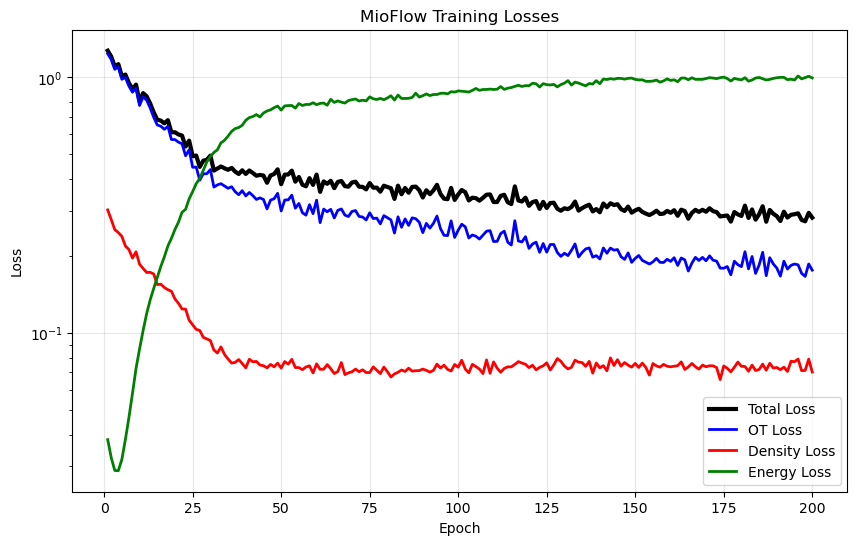

In [117]:
epochs = history['epoch']

plt.figure(figsize=(10, 6))
plt.plot(epochs, history['total_loss'], 'k-', linewidth=3, label='Total Loss')
plt.plot(epochs, history['ot_loss'], 'b-', linewidth=2, label='OT Loss')
plt.plot(epochs, history['density_loss'], 'r-', linewidth=2, label='Density Loss')
plt.plot(epochs, history['energy_loss'], 'g-', linewidth=2, label='Energy Loss')

plt.title('MioFlow Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Optional: log scale for better visualization
plt.show()

In [118]:
# Get initial condition and subsample points
X_0_full = mioflow_data.get_initial_condition()  # [full_size, n_features]
n_pts = 500  # or whatever subsample size you want
indices = torch.randperm(X_0_full.size(0))[:n_pts]
X_0_sample = X_0_full[indices]  # [n_pts, n_features]

# Get time range and create 100 time bins
times = mioflow_data.times
t_min, t_max = min(times), max(times)
t_bins = torch.linspace(t_min, t_max, 100)  # [100]

# Integrate trajectories
with torch.no_grad():
    trajectories = odeint(mioflow_model, X_0_sample, t_bins)  # [100, n_pts, n_features]

# Rearrange to [n_pts, 100, n_features] as requested
trajectories = trajectories.permute(1, 0, 2)  # [n_pts, 100, n_features]

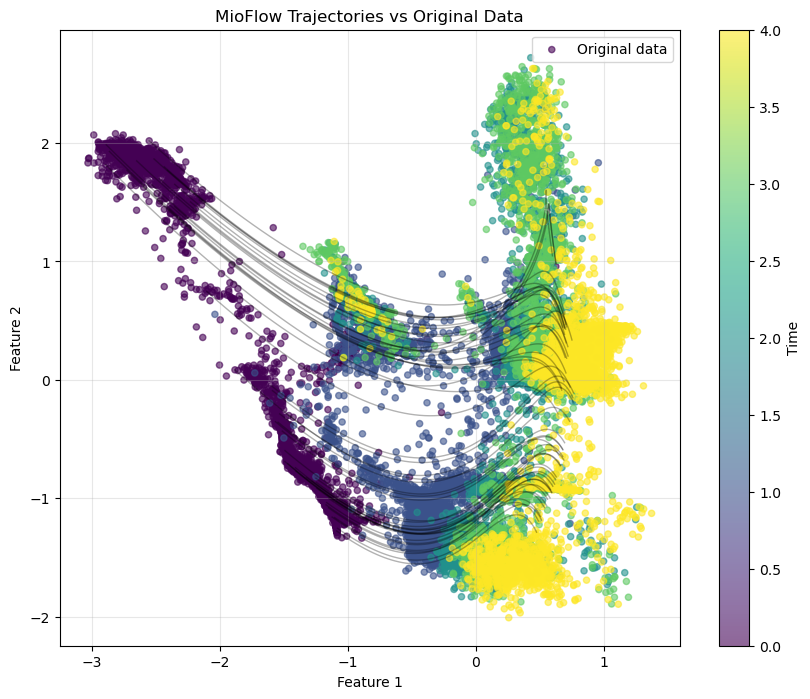

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 2D data - if higher dimensional, you might want to project first
# Get all original data points and their times
all_points = []
all_times = []
for i in range(len(mioflow_data.time_series_data)):
    points, time = mioflow_data.time_series_data[i]
    all_points.append(points)
    all_times.extend([time] * len(points))

all_points = np.vstack(all_points)  # [total_points, n_features]
all_times = np.array(all_times)     # [total_points]

# Create the plot
plt.figure(figsize=(10, 8))

# Plot original data points colored by time
scatter = plt.scatter(all_points[:, 0], all_points[:, 1], 
                     c=all_times, cmap='viridis', alpha=0.6, s=20,
                     label='Original data')

# Plot trajectories as lines
for i in range(min(50, trajectories.size(0))):  # Plot first 50 trajectories to avoid clutter
    traj = trajectories[i].cpu().numpy()  # [100, n_features]
    plt.plot(traj[:, 0], traj[:, 1], 'k-', alpha=0.3, linewidth=1)

# Add colorbar
plt.colorbar(scatter, label='Time')

plt.title('MioFlow Trajectories vs Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()